In [1]:
# Add these imports before importing segmentation_models
import keras.utils as utils
import keras.backend as K
import keras.models as models
import keras.layers as layers
utils.generic_utils = utils

2025-04-06 23:51:46.408813: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-06 23:51:46.427892: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743983506.450501  216992 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743983506.457346  216992 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743983506.475674  216992 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Add this at the beginning of your notebook
import tensorflow as tf

# Option 1: Force CPU execution
# Uncomment this to force CPU usage
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Option 2: Configure GPU memory growth (preferred)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"Found {len(physical_devices)} GPU(s)")
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print(f"Enabled memory growth for {device}")
else:
    print("No GPU found, using CPU")

Found 1 GPU(s)
Enabled memory growth for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam  # Correct way in TF 2.x
import segmentation_models as sm


bf_dir = "./final_bf"
gt_dir = "./final_edge_detected"
image_size = (256, 256)

bf_images = sorted([os.path.join(bf_dir, f) for f in os.listdir(bf_dir) if f.endswith('.png')])
gt_images = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith('.png')])

assert len(bf_images) == len(gt_images), "Number of images and masks do not match"

random_seed = 42
np.random.seed(random_seed)

# Train-test split (80% training, 20% testing)
train_bf, test_bf, train_gt, test_gt = train_test_split(bf_images, gt_images, test_size=0.2, random_state=random_seed)

def load_image(image_path, size=image_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    image = cv2.resize(image, size)
    image = np.stack((image,) * 3, axis=-1)  # Convert to 3 channels (if needed)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_mask(mask_path, size=image_size):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size)
    mask = mask / 255.0  # Normalize to [0, 1]
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    return mask

X_train = np.array([load_image(img_path) for img_path in train_bf])
y_train = np.array([load_mask(mask_path) for mask_path in train_gt])

# Load testing images and masks
X_test = np.array([load_image(img_path) for img_path in test_bf])
y_test = np.array([load_mask(mask_path) for mask_path in test_gt])

print(f'Training Images: {X_train.shape}, Training Masks: {y_train.shape}')
print(f'Testing Images: {X_test.shape}, Testing Masks: {y_test.shape}')

# Define the backbone you want to use
BACKBONE = 'resnet34'  # You can also try 'resnet50', 'efficientnetb0', etc.
preprocess_input = sm.get_preprocessing(BACKBONE)

# Preprocess your images (assuming you have already preprocessed your images in the previous step)
X_train = np.array([preprocess_input(img) for img in X_train])
X_test = np.array([preprocess_input(img) for img in X_test])

# Load the pretrained U-Net model
model = sm.Unet(BACKBONE, 
                encoder_weights='imagenet',  # Pre-trained on ImageNet
                input_shape=(256, 256, 3),   # Match your input image size
                classes=1,                   # Binary segmentation
                activation='sigmoid')        # Use 'softmax' if doing multi-class segmentation

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()  # View the model architecture

Segmentation Models: using `keras` framework.
Training Images: (814, 256, 256, 3), Training Masks: (814, 256, 256, 1)
Testing Images: (204, 256, 256, 3), Testing Masks: (204, 256, 256, 1)


I0000 00:00:1743983784.896650  216992 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 37511 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 256, 256,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 256, 256,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 262, 262,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 128, 128,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 128, 128,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 128, 128,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 130, 130,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 64, 64,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 64, 64,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 64, 64,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 64, 64,    │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 64, 64,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 64, 64,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 66, 66,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 64, 64,    │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 64, 64,    │      4,096 │ stage1_unit1_rel

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [7]:
# Save the model
model.save('unet_model.h5')
print("Model saved to unet_model.h5")

# Load the model fresh
from tensorflow.keras.models import load_model
fresh_model = load_model('unet_model.h5', compile=False)
fresh_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print("Model reloaded successfully")

# Now try prediction with the fresh model
predicted_mask = fresh_model.predict(
    np.expand_dims(test_image, axis=0), 
    batch_size=1, 
    verbose=0
)[0]

Model saved to unet_model.h5
Model reloaded successfully


E0000 00:00:1743984415.378847  218860 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1743984415.416158  218860 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-04-07 00:06:55.423532: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at xla_ops.cc:591 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/usr/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/tmp/ipykernel_216992/1713654412.py", line 12, in <module>

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 560, in predict

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_15016]

Configured memory growth for 1 GPU(s)
Test image shape: (256, 256, 3), dtype: float64
Test mask shape: (256, 256, 1), dtype: float64


E0000 00:00:1743984257.153275  218862 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1743984257.191327  218862 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
2025-04-07 00:04:17.201997: W tensorflow/core/framework/op_kernel.cc:1857] OP_REQUIRES failed at xla_ops.cc:591 : FAILED_PRECONDITION: DNN library initialization failed. Look at the er

Error during prediction/visualization: FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/usr/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/su

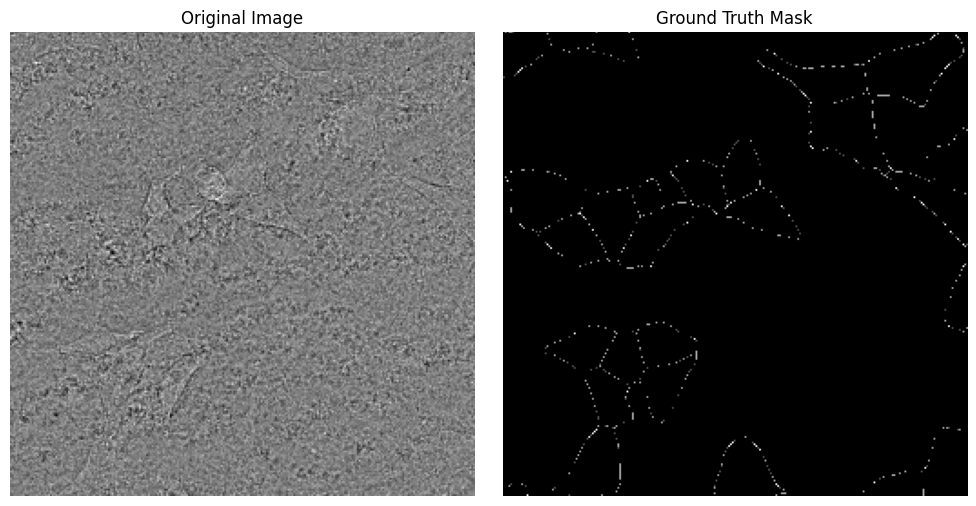

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Configure GPU memory growth (ADD THIS AT THE BEGINNING!)
try:
    physical_devices = tf.config.list_physical_devices('GPU')
    if physical_devices:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print(f"Configured memory growth for {len(physical_devices)} GPU(s)")
    else:
        print("No GPUs found, using CPU")
except Exception as e:
    print(f"GPU configuration error: {e}")

# Pick a random test image
random_index = random.randint(0, len(X_test) - 1)
test_image = X_test[random_index]
test_mask = y_test[random_index]

# Print diagnostic information
print(f"Test image shape: {test_image.shape}, dtype: {test_image.dtype}")
print(f"Test mask shape: {test_mask.shape}, dtype: {test_mask.dtype}")

try:
    # Make prediction (with batch_size=1 explicitly set)
    predicted_mask = model.predict(
        np.expand_dims(test_image, axis=0), 
        batch_size=1, 
        verbose=1
    )[0]
    
    # Convert predicted mask to binary (thresholding)
    threshold = 0.5
    predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)
    
    # Plotting the results
    plt.figure(figsize=(15, 5))
    
    # Original Image - convert 3-channel to grayscale for display
    plt.subplot(1, 3, 1)
    plt.imshow(np.mean(test_image, axis=2), cmap='gray')
    plt.title('Original Brightfield Image')
    plt.axis('off')
    
    # Ground Truth Mask
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(test_mask), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(predicted_mask_binary), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error during prediction/visualization: {type(e).__name__}: {e}")
    
    # Still show the input image and ground truth even if prediction fails
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(np.mean(test_image, axis=2), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(np.squeeze(test_mask), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [4]:
import random
import numpy as np
import matplotlib.pyplot as plt


# Pick a random test image
random_index = random.randint(0, len(X_test) - 1)
test_image = X_test[random_index]
test_mask = y_test[random_index]

# Make prediction
predicted_mask = model.predict(np.expand_dims(test_image, axis=0))[0]

# Convert predicted mask to binary (thresholding)
threshold = 0.5
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(test_image, cmap='gray')  # Ensure proper visualization
plt.title('Original Brightfield Image')
plt.axis('off')

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(test_mask), cmap='gray')  # Squeeze if necessary
plt.title('Ground Truth Mask')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predicted_mask_binary), cmap='gray')  # Squeeze for proper display
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()


I0000 00:00:1743984035.212945  218859 service.cc:152] XLA service 0x7f6ea8015b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743984035.212975  218859 service.cc:160]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2025-04-07 00:00:35.308804: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
E0000 00:00:1743984035.875997  218859 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was compiled with: 9.3.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0000 00:00:1743984035.914490  218859 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.1.0 but source was com

FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/usr/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever

  File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once

  File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/var/tmp/ipykernel_216992/595006387.py", line 12, in <module>

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 560, in predict

  File "/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/keras/src/backend/tensorflow/trainer.py", line 259, in one_step_on_data_distributed

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_4097]

In [28]:
from tensorflow.keras.metrics import MeanIoU

# Evaluate on the test set
evaluation = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {evaluation[0]}")
print(f"Test Accuracy: {evaluation[1]}")

# Compute Mean IoU
num_classes = 2  # Background and Edge Detected Mask
IOU_keras = MeanIoU(num_classes=num_classes)
IOU_keras.update_state(y_test, (model.predict(X_test) > threshold).astype(np.uint8))
print(f"Mean IoU = {IOU_keras.result().numpy()}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 924ms/step - accuracy: 0.9902 - loss: 0.4852
Test Loss: 0.4851360321044922
Test Accuracy: 0.9904188513755798
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 737ms/step
Mean IoU = 0.4997395873069763


In [1]:
import torch
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
url = pmm.util.get_pretrained_microscopynet_url('resnet50', 'micronet')
model.load_state_dict(model_zoo.load_url(url))
model.eval()  # <- MicrosNet model for classifcation or transfer learning

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /home/suriya/.cache/torch/hub/v0.10.0.zip
/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://nasa-public-data.s3.amazonaws.com/microscopy_segmentation_models/resnet50_pretrained_microscopynet_v1.1.pth.tar" to /home/suriya/.cache/torch/hub/checkpoints/resnet50_pretrained_microscopynet_v1.1.pth.tar
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.0MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [2]:
import pretrained_microscopy_models as pmm

# setup a UNet model with a ResNet50 backbone.
model = pmm.segmentation_training.create_segmentation_model('Unet', 'resnet50', 'micronet', classes=3)

# See examples to train and make predictions with model.


Training Images: (814, 256, 256, 3), Training Masks: (814, 256, 256, 1)
Testing Images: (204, 256, 256, 3), Testing Masks: (204, 256, 256, 1)


Using cache found in /home/suriya/.cache/torch/hub/pytorch_vision_v0.10.0
/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/suriya/cyto-mask/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Predicted Class: 33


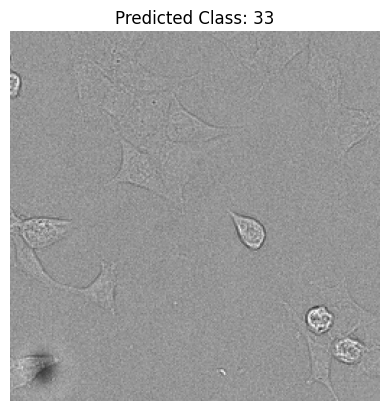

In [6]:
import torch
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import cv2
from sklearn.model_selection import train_test_split

bf_dir = "./final_bf"
gt_dir = "./final_edge_detected"
image_size = (256, 256)

bf_images = sorted([os.path.join(bf_dir, f) for f in os.listdir(bf_dir) if f.endswith('.png')])
gt_images = sorted([os.path.join(gt_dir, f) for f in os.listdir(gt_dir) if f.endswith('.png')])

assert len(bf_images) == len(gt_images), "Number of images and masks do not match"

random_seed = 42
np.random.seed(random_seed)

# Train-test split (80% training, 20% testing)
train_bf, test_bf, train_gt, test_gt = train_test_split(bf_images, gt_images, test_size=0.2, random_state=random_seed)

def load_image(image_path, size=image_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    image = cv2.resize(image, size)
    image = np.stack((image,) * 3, axis=-1)  # Convert to 3 channels (if needed)
    image = image / 255.0  # Normalize to [0, 1]
    return image

def load_mask(mask_path, size=image_size):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, size)
    mask = mask / 255.0  # Normalize to [0, 1]
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    return mask

X_train = np.array([load_image(img_path) for img_path in train_bf])
y_train = np.array([load_mask(mask_path) for mask_path in train_gt])

# Load testing images and masks
X_test = np.array([load_image(img_path) for img_path in test_bf])
y_test = np.array([load_mask(mask_path) for mask_path in test_gt])

print(f'Training Images: {X_train.shape}, Training Masks: {y_train.shape}')
print(f'Testing Images: {X_test.shape}, Testing Masks: {y_test.shape}')

# Load the pretrained ResNet50 model from MicroscopyNet
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
url = pmm.util.get_pretrained_microscopynet_url('resnet50', 'micronet')  # Get the pretrained weights URL
model.load_state_dict(model_zoo.load_url(url))  # Load the pretrained weights
model.eval()  # Set the model to evaluation mode

# Example: Use the model for classification or transfer learning
# Assuming `X_test` is your test dataset and `y_test` is the ground truth

# Pick a random test image
random_index = random.randint(0, len(X_test) - 1)
test_image = X_test[random_index]

# Preprocess the test image for ResNet50
test_image_tensor = torch.tensor(test_image, dtype=torch.float32).unsqueeze(0)  # Add batch dimension
test_image_tensor = test_image_tensor.permute(0, 3, 1, 2)  # Convert to (N, C, H, W) format if needed

# Make prediction
with torch.no_grad():
    prediction = model(test_image_tensor)

# Process the prediction (e.g., classification or segmentation)
# For classification, you can use `torch.argmax` to get the predicted class
predicted_class = torch.argmax(prediction, dim=1).item()

# Print the predicted class
print(f"Predicted Class: {predicted_class}")

# Visualization (if applicable)
plt.imshow(test_image, cmap='gray')
plt.title(f"Predicted Class: {predicted_class}")
plt.axis('off')
plt.show()

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Pick a random test image
random_index = random.randint(0, len(X_test) - 1)
test_image = X_test[random_index]
test_mask = y_test[random_index]  # Ground truth mask

# Preprocess the test image (if necessary)
test_image_input = np.expand_dims(test_image, axis=0)  # Add batch dimension

# Make prediction
predicted_mask = model.predict(test_image_input)[0]  # Remove batch dimension from prediction

# Convert predicted mask to binary (thresholding)
threshold = 0.5
predicted_mask_binary = (predicted_mask > threshold).astype(np.uint8)

# Plotting the results
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(test_image, cmap='gray')  # Ensure proper visualization
plt.title('Original Brightfield Image')
plt.axis('off')

# Ground Truth Mask
plt.subplot(1, 3, 2)
plt.imshow(np.squeeze(test_mask), cmap='gray')  # Squeeze if necessary
plt.title('Ground Truth Mask')
plt.axis('off')

# Predicted Mask
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(predicted_mask_binary), cmap='gray')  # Squeeze for proper display
plt.title('Predicted Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

AttributeError: 'ResNet' object has no attribute 'predict'